In [326]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import math
import scipy as sp

In [327]:
import pystan

In [2]:
Nile = pd.read_excel('nile_river.xlsx')

# カルマンフィルタ実装

$y = y_t$ = 観測値

y_forecast = ${\hat{y}}$ = 観測値の予測値

y_resid,t = $y_t - {\hat{y}}$ = 観測値の予測残差

mu_pre = $\mu_{t-1\|t-1}$ = 前期の状態

mu_forecast = $\mu_t$ = 状態の予測値

mu_filter =$\mu_{t|t}$ = 補正された状態の予測値(フィルタ化推定量)

P_pre = $P_{t-1|t-1}$→ $\mu_{t-1|t-1}$ ~$N(0,P_{t-1|t-1})$ = $\mu_{t-1|t-1}$ の予測誤差の分散 = t-1時点の予測したフィルタ化推定量自体のばらつき=t-1時点の傾き(トレンド)のばらつき

P_forecast = $P_{t}$→ $\mu_{t}$ ~$N(0,P_{t})$ = $\mu_{t}$ の予測誤差の分散

P_filter = $P_{t|t}$→ $\mu_{t|t}$ ~$N(0,P_{t|t})$ = $\mu_{t|t}$ の予測誤差の分散

F = y_resid,t ~ $N(0,F)$= y_residの分散

K = カルマンゲイン

sigma_W =$ \sigma_{w}^2 → \mu_t = \mu_{t-1} + w_{t}$ ~ $N(0, \sigma_{w}^2)$ =  過程誤差の分散

sigma_v =$ \sigma_{v}^2 → y_t = y_{t-1} + v_{t}$ ~ $N(0, \sigma_{v}^2)$ = 観測誤差の分散

$$
    % 空白は表示に影響しない。コメントは"%"で始める
    % 下付き文字は"_a"、上付き文字は"^a"
    % 改行は"\\"を付ける
    % 複数文字を1要素とする際は{...}で囲う
    % 空白は"\quad"
$$

In [73]:
#ローカルレベルの状態空間モデル
#関数の引数＝観測値,前期の状態の予測値,前期の状態の予測値の予測誤差の分散,過程誤差の分散、観測誤差の分散
def kfLocalLevel(y,mu_pre,P_pre,sigma_w,sigma_v):
    #step1 予測
    #ローカルレベルなので前期の状態の予測値がそのまま今期の状態の予測値になる
    mu_forecast = mu_pre
    #状態のばらつき
    P_forecast = P_pre + sigma_w
    #ローカルレベルなので今期の状態の予測値がそのまま今期の予測した観測値になる
    y_forecast = mu_forecast
    #残差のばらつき
    F = P_forecast + sigma_v
    
    #step2 状態の補正（フィルタリング）
    K = P_forecast / (P_forecast + sigma_v)
    y_resid = y - y_forecast
    #状態を予測残差分だけ補正するのではなく、カルマンフィルタを通してその影響度を少し小さくして補正する
    """なぜそんなことをする必要があるのかというと、理由は予測残差にある。予測誤差は、実観測値-予測値で決まる。その時実観測値の分散が
    大きければその観測値は信頼性が低いといえる。このようなときに残差を通してmu_filter、つまり状態を補正しても意味がない。なぜなら残差
    が出た理由は観測値のほうにあると思われるからだ。逆に予測値は、状態を用いて予測している。もとの状態も予測された値なので、それ自体の
    分散が大きければ予測マシーンとして精度が低いことになる。こっちのケースは補正を多くしたほうがいい。これらの計算を数式としてうまく
    やってくれているのがカルマンゲインなのである"""
    mu_filter = mu_forecast + K * y_resid
    P_filter = (1 - K) * P_forecast
    
    #結果の格納
    index = ['sigma_w','sigma_v','mu_pre','mu_forecast','P_pre','P_forecast','y_forecast','mu_filter','P_filter','y_resid','F','K']
    result = pd.DataFrame(np.array([sigma_w,sigma_v,mu_pre,mu_forecast,P_pre,P_forecast,y_forecast,mu_filter,P_filter,y_resid,F,K]),index=index)
    return result.T

In [220]:
#状態を推定する
N =len(Nile)
#状態の推定値を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
mu_filter = np.zeros(N)
#状態の初期値は0。パラメータだが、最尤推定できる種類のものじゃないから０でいい
mu_zero = 0
#時点0の情報(mu_zero)があるので、観測値などの配列と長さが１要素分異なることに注意
mu_filter = np.append(mu_zero,mu_filter)
#状態の予測誤差の分散を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
P_filter = np.zeros(N)
#状態の予測誤差の分散の初期値は10の7乗＝パラメータだけど何入れても収束する結果にはあまり影響ない
P_zero = 10**7
#時点0の情報(P_zero)があるので、観測値などの配列と長さが１要素分異なることに注意
P_filter = np.append(P_zero,P_filter)
#観測値の予測誤差を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
y_resid = np.zeros(N)
#観測値の予測誤差の分散を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
F = np.zeros(N)
#カルマンゲインを格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
K = np.zeros(N)
#過程誤差の分散。1000でとりあえず初期化＝パラメーター
sigma_w = 1000
#観測誤差の分散。10000でとりあえず初期化＝パラメーター
sigma_v = 10000

In [77]:
Nile.iloc[0,1]

1120

In [221]:
index = ['sigma_w','sigma_v','mu_pre','mu_forecast','P_pre','P_forecast','y_forecast','mu_filter','P_filter','y_resid','F','K']
kekka = pd.DataFrame(np.zeros((N,len(index))),columns=index)

for i in range(N):
    kekka.iloc[i] = kfLocalLevel(Nile.iloc[i,1]
                                 ,mu_pre=mu_filter[i]
                                 ,P_pre = P_filter[i]
                                 ,sigma_w = sigma_w
                                 ,sigma_v = sigma_v).iloc[0]

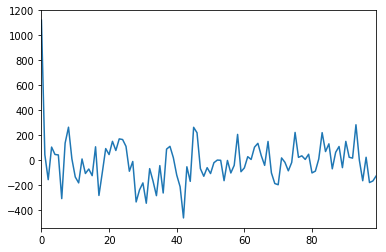

In [178]:
kekka['y_resid'].plot()

# パラメータ(過程誤差・観測誤差)の推定:対数尤度の計算
### 観測値の予測残差(y_resid)が$N(0,F_t)$となっており、正規分布に従うので、これを利用して対数尤度を計算する

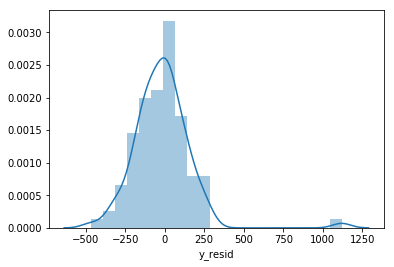

In [218]:
#確かに正規分布に従っている
sns.distplot(kekka['y_resid'])

In [9]:
log_L = []

# 3. 1-2を観測時点分だけ行う
for a in range(len(kekka)):
    data = kekka['y_resid'][a]
    var = kekka['F'][a]
    # 1.正規分布の確率密度を計算
    #平均0,標準偏差sqrt(var)に従う正規分布の確率密度計算
    # 2.対数を取る
    log_L.append((math.log(norm.pdf(data,0,math.sqrt(var)))))
    
# 4. 3の結果をSumする（尤度だから普通掛け算だけど、対数取っているので足し算）
sum(log_L)

-4474.336667876975

In [10]:
#対数尤度を求める別解
log_x = []
for a in range(len(kekka)):
    x = math.log(kekka['F'][a])
    log_x.append(x + kekka['y_resid'][a]**2 / kekka['F'][a])

In [11]:
-1 * (N/2) * math.log(2 * math.pi) - 1/2 * sum(log_x)

-4474.336667876975

In [262]:
# sigma_wとsigma_vを返す最尤法の関数を作成
def calkLogLik(sigma):
    sigma_w = np.exp(sigma[0])
    sigma_v = np.exp(sigma[1])
    
    #変数を定義
    N =len(Nile)
    #状態の推定値を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
    mu_filter = np.zeros(N)
    #状態の初期値は0。パラメータだが、最尤推定できる種類のものじゃないから０でいい
    mu_zero = 0
    #時点0の情報(mu_zero)があるので、観測値などの配列と長さが１要素分異なることに注意
    mu_filter = np.append(mu_zero,mu_filter)
    #状態の予測誤差の分散を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
    P_filter = np.zeros(N)
    #状態の予測誤差の分散の初期値は10の7乗＝パラメータだけど何入れても収束する結果にはあまり影響ない
    P_zero = 10**7
    #時点0の情報(P_zero)があるので、観測値などの配列と長さが１要素分異なることに注意
    P_filter = np.append(P_zero,P_filter)
    #観測値の予測誤差を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
    y_resid = np.zeros(N)
    #観測値の予測誤差の分散を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
    F = np.zeros(N)
    #カルマンゲインを格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
    K = np.zeros(N)

    
    #カルマンフィルタの実行
    index = ['mu_filter','P_filter','y_resid','F','K']
    kekka = pd.DataFrame(np.zeros((N,len(index))),columns=index)

    for i in range(N):
        kekka.iloc[i] = kfLocalLevel(Nile.iloc[i,1]
                                     ,mu_pre=mu_filter[i]
                                     ,P_pre = P_filter[i]
                                     ,sigma_w = sigma_w
                                     ,sigma_v = sigma_v).iloc[0]
        
        mu_filter[i+1] = kekka['mu_filter'].iloc[i]
        P_filter[i+1] = kekka['P_filter'].iloc[i]
        y_resid[i] = kekka['y_resid'].iloc[i]
        F[i] = kekka['F'].iloc[i]
        K[i] = kekka['K'].iloc[i]
        
    #対数尤度を求める別解
    log_x = []
    for a in range(len(kekka)):
        x = np.log(kekka['F'][a])
        log_x.append(x + kekka['y_resid'][a]**2 / kekka['F'][a])
#         try:
#             x = math.log(kekka['F'][a])
#             log_x.append(x + kekka['y_resid'][a]**2 / kekka['F'][a])
#         except ValueError:
#             pass
        
    return 1/2 * sum(log_x)


In [265]:
init_param = np.array([1,1])
result= sp.optimize.minimize(calkLogLik,init_param,method='bfgs')

In [263]:
# sigma_wとsigma_vを返す最尤法の関数を作成
# 上記のoptimize関数を使って推定したsigma_w,sigma_vを使って実際にモデルを動かす
def calkLogLik_best(sigma_best):
    sigma_w = np.exp(sigma_best[0])
    sigma_v = np.exp(sigma_best[1])
    
    #変数を定義
    N =len(Nile)
    #状態の推定値を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
    mu_filter = np.zeros(N)
    #状態の初期値は0。パラメータだが、最尤推定できる種類のものじゃないから０でいい
    mu_zero = 0
    #時点0の情報(mu_zero)があるので、観測値などの配列と長さが１要素分異なることに注意
    mu_filter = np.append(mu_zero,mu_filter)
    #状態の予測誤差の分散を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
    P_filter = np.zeros(N)
    #状態の予測誤差の分散の初期値は10の7乗＝パラメータだけど何入れても収束する結果にはあまり影響ない
    P_zero = 10**7
    #時点0の情報(P_zero)があるので、観測値などの配列と長さが１要素分異なることに注意
    P_filter = np.append(P_zero,P_filter)
    #観測値の予測誤差を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
    y_resid = np.zeros(N)
    #観測値の予測誤差の分散を格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
    F = np.zeros(N)
    #カルマンゲインを格納する箱を用意する（観測値の数だけ長さが必要だから、np.zeros(N)で初期化している）
    K = np.zeros(N)

    
    #カルマンフィルタの実行
    index = ['mu_filter','P_filter','y_resid','F','K']
    kekka = pd.DataFrame(np.zeros((N,len(index))),columns=index)

    for i in range(N):
        kekka.iloc[i] = kfLocalLevel(Nile.iloc[i,1]
                                     ,mu_pre=mu_filter[i]
                                     ,P_pre = P_filter[i]
                                     ,sigma_w = sigma_w
                                     ,sigma_v = sigma_v).iloc[0]
        
        mu_filter[i+1] = kekka['mu_filter'].iloc[i]
        P_filter[i+1] = kekka['P_filter'].iloc[i]
        y_resid[i] = kekka['y_resid'].iloc[i]
        F[i] = kekka['F'].iloc[i]
        K[i] = kekka['K'].iloc[i]
        
    #対数尤度を求める別解
    log_x = []
    for a in range(len(kekka)):
        x = np.log(kekka['F'][a])
        log_x.append(x + kekka['y_resid'][a]**2 / kekka['F'][a])
#         try:
#             x = math.log(kekka['F'][a])
#             log_x.append(x + kekka['y_resid'][a]**2 / kekka['F'][a])
#         except ValueError:
#             pass
        
    return 1/2 * sum(log_x), mu_filter,P_filter,y_resid,F,K


In [266]:
best_params = np.exp(result.x)
result,mu_filter,P_filter,y_resid,F,L = calkLogLik_best(best_params)

# 平滑化

In [267]:
#_postは一時点未来の情報を示す。
def smoothLocalLevel(mu_filterd,P_filterd,r_post,s_post,F_post,y_resid_post,K_post):
    #状態平滑化漸化式。rは状態平滑化漸化式のパラメータ。この式は平滑化状態を計算するのに便利だから存在する
    #この値は、要は状態の分散(P)を補正する補正力といっていい。
    r = y_resid_post /  F_post + (1-K_post) * r_post
    #平滑化状態=T時点までのすべてのデータYtが得られた条件における条件付き期待値
    # 平滑化漸化式の値が状態の分散を補正する。それによって平滑化状態が形成される。
    # rによって分散(P)が補正されて小さくなるので、平滑化状態は、フィルタ推定量よりも精度がよくなる
    mu_smooth = mu_filterd + P_filterd * r
    # 状態分散平滑化漸化式。sは状態分散平滑化漸化式のパラメータ
    s = 1/F_post + (1 - K_post)**2 * s_post
    # 平滑化分散状態=mu_smoothの分散
    P_smooth = P_filterd - P_filterd**2 * s
    return mu_smooth,P_smooth,r,s

In [268]:
# 状態の推定
# 平準化状態
mu_smooth = np.zeros(N + 1)
# 平準化状態分散
P_smooth = np.zeros(N + 1)
#漸化式のパラメタ=初期値は0
r = np.zeros(N)
s = np.zeros(N)
#最後のデータは、フィルタリングの結果とスムージングの結果が一致する
mu_smooth[N] = mu_filter[N]
P_smooth[N] = P_filter[N]

In [269]:
index = ['mu_smooth','P_smooth','r','s']
for idx in index:
    kekka[idx] = np.zeros(len(kekka))
for i in reversed(range(N)):
    param_tuple = smoothLocalLevel(
                            mu_filter[i],
                            P_filter[i],
                            r[i],
                            s[i],
                            F[i],
                            y_resid[i],
                            K[i])
    kekka['mu_smooth'].iloc[i] = param_tuple[0]
    kekka['P_smooth'].iloc[i] = param_tuple[1]
    kekka['r'].iloc[i] = param_tuple[2]
    kekka['s'].iloc[i] = param_tuple[3]
    mu_smooth[i] = kekka['mu_smooth'].iloc[i]
    P_smooth[i] = kekka['P_smooth'].iloc[i]
    r[i-1] = kekka['r'].iloc[i]
    s[i-1] = kekka['s'].iloc[i]

# ライブラリーを利用した状態空間モデル

In [312]:
# 統計モデル
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

In [316]:
# # datetimeindexの形式じゃないとパラメータ推定でエラーがでる
# idx = pd.date_range('2014-11-01 10:00', periods=len(Nile), freq='D')
# Nile['idx'] = idx
# Nile = Nile.set_index([idx])
# Nile = Nile.reindex(['Nile (y)'],axis=1)

# 日付形式で読み込む
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', index_col='Month', date_parser=dateparse, dtype='float')

# 日付形式にする
ts = data['#Passengers'] 
ts.head()

# プロット
# plt.plot(ts)

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64

C:\Users\ry00i\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                        Unobserved Components Results                         
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                    local level   Log Likelihood                -705.955
Date:                Wed, 04 Mar 2020   AIC                           1415.909
Time:                        21:38:27   BIC                           1421.835
Sample:                    01-01-1949   HQIC                          1418.317
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.312e-07     85.482   1.54e-09      1.000    -167.542     167.542
sigma2.level      1136.4043    176.695      6.431      0.000     790.088    1482.721
Ljung-Box (Q):              

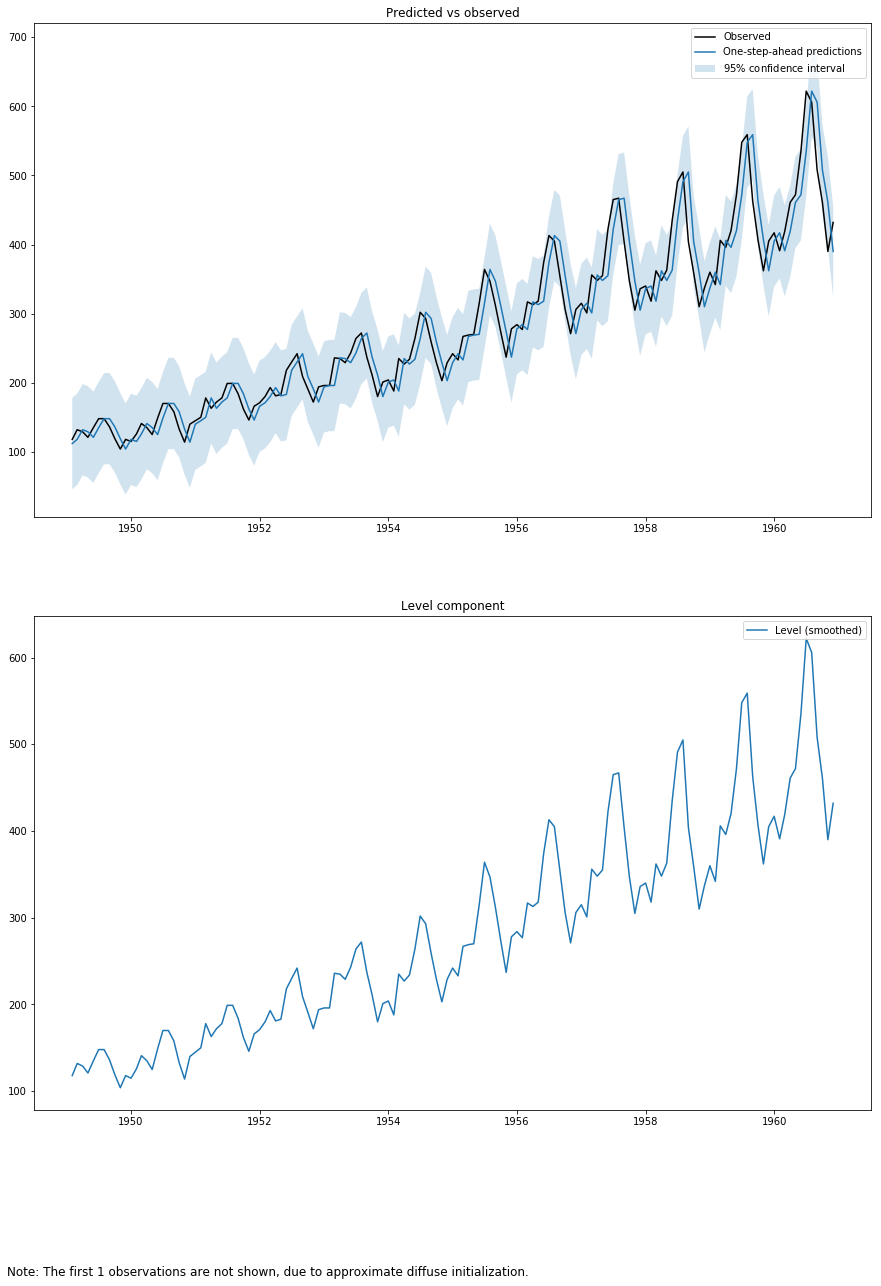

In [317]:
# ローカルレベルモデルの構築
mod_local_level = sm.tsa.UnobservedComponents(ts, 'local level')
# 最尤法によるパラメタの推定
res_local_level = mod_local_level.fit()
# 推定されたパラメタ一覧
print(res_local_level.summary())
# 推定された状態・トレンドの描画
rcParams['figure.figsize'] = 15, 20
fig = res_local_level.plot_components()

C:\Users\ry00i\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 5.015259
         Iterations: 19
         Function evaluations: 30
         Gradient evaluations: 30
                        Unobserved Components Results                         
Dep. Variable:            #Passengers   No. Observations:                  144
Model:             local linear trend   Log Likelihood                -722.197
Date:                Sat, 07 Mar 2020   AIC                           1450.394
Time:                        15:24:11   BIC                           1459.262
Sample:                    01-01-1949   HQIC                          1453.998
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    86.590

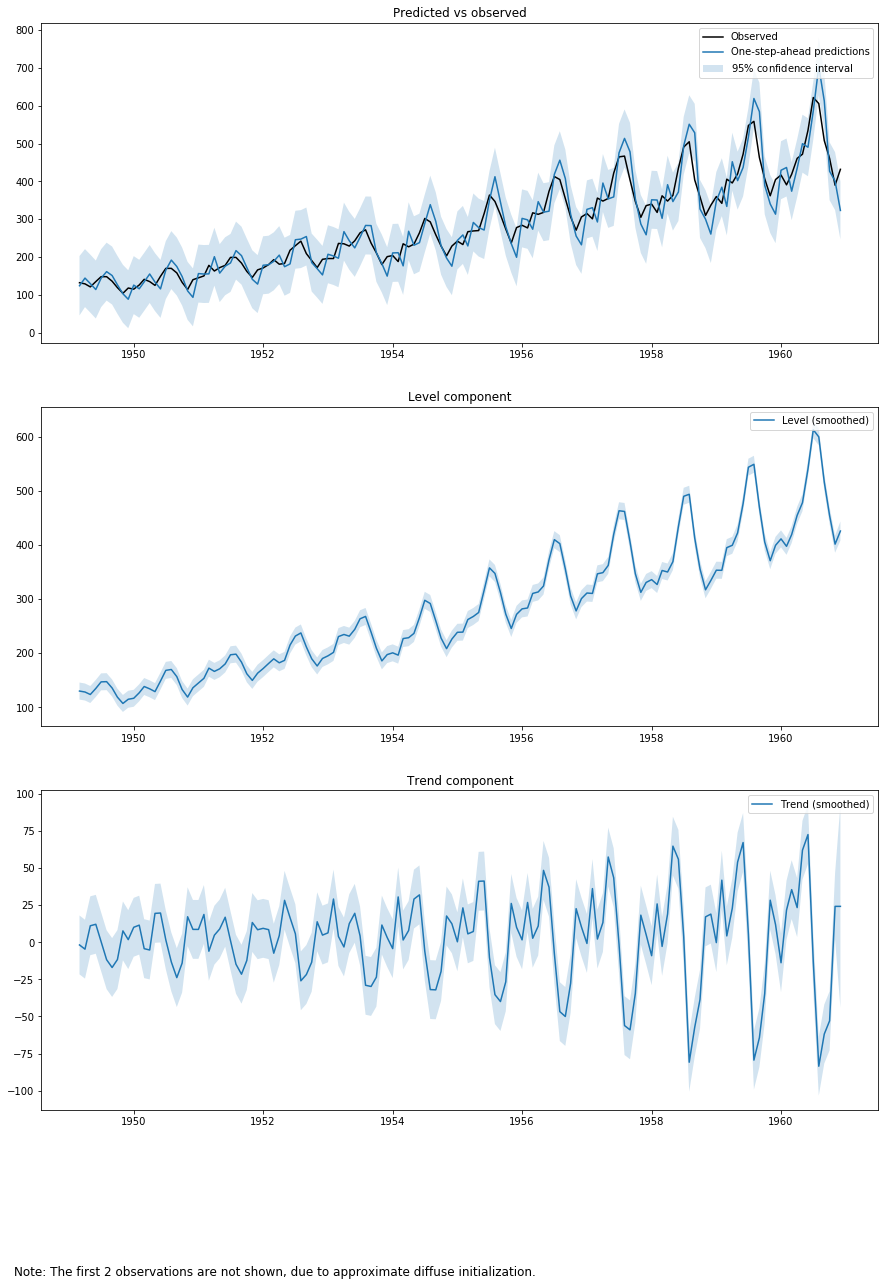

In [322]:
# ローカル線形トレンドモデル
mod_trend = sm.tsa.UnobservedComponents(ts,'local linear trend')
# 最尤法によるパラメタの推定
# ワーニングが出たのでBFGS法で最適化する
res_trend = mod_trend.fit(method='bfgs')
# 推定されたパラメタ一覧
print(res_trend.summary())
# 推定された状態・トレンドの描画
rcParams['figure.figsize'] = 15, 20
fig = res_trend.plot_components()

C:\Users\ry00i\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 3.969241
         Iterations: 148
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: 3.969241
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                            Unobserved Components Results                            
Dep. Variable:                   #Passengers   No. Observations:                  144
Model:                           local level   Log Likelihood                -571.571
                   + stochastic seasonal(12)   AIC                           1149.142
Date:                       Wed, 04 Mar 2020   BIC                           1157.790
Time:                               21:40:56   HQIC                          1152.656
Sample:                           01-01-1949                                         
                                - 12-01-1960                                         
Cov

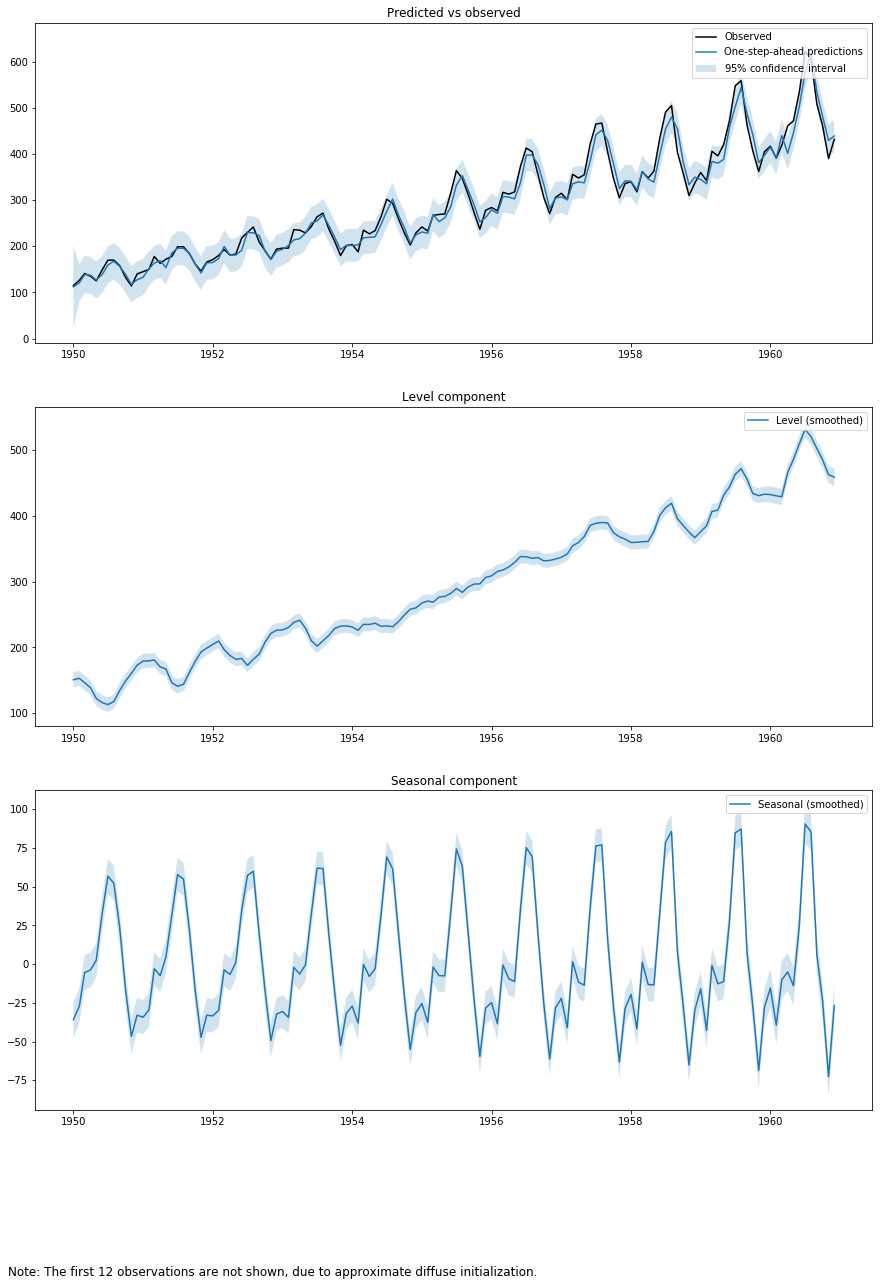

In [320]:
# 季節変動ありのローカルレベルモデル

mod_season_local_level = sm.tsa.UnobservedComponents(
    ts,
    'local level',
    seasonal=12
)

# まずはNelder-Meadでパラメタを推定し、その結果を初期値としてまた最適化する。2回目はBFGSを使用。
# これくらいやらないとパラメタがうまく推定できない
res_season_local_level = mod_season_local_level.fit(
    method='bfgs', 
    maxiter=500, 
    start_params=mod_season_local_level.fit(method='nm', maxiter=500).params,
)

# 推定されたパラメタ一覧
print(res_season_local_level.summary())

# 推定された状態・トレンド・季節の影響の描画
rcParams['figure.figsize'] = 15, 20
fig = res_season_local_level.plot_components()

C:\Users\ry00i\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 495
         Function evaluations: 827
Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                            Unobserved Components Results                            
Dep. Variable:                   #Passengers   No. Observations:                  144
Model:                    local linear trend   Log Likelihood                -566.051
                   + stochastic seasonal(12)   AIC                           1140.103
Date:                       Wed, 04 Mar 2020   BIC                           1151.603
Time:                               21:41:19   HQIC                          1144.776
Sample:                           01-01-1949                                         
                                - 12-01-1960                                         
Cov

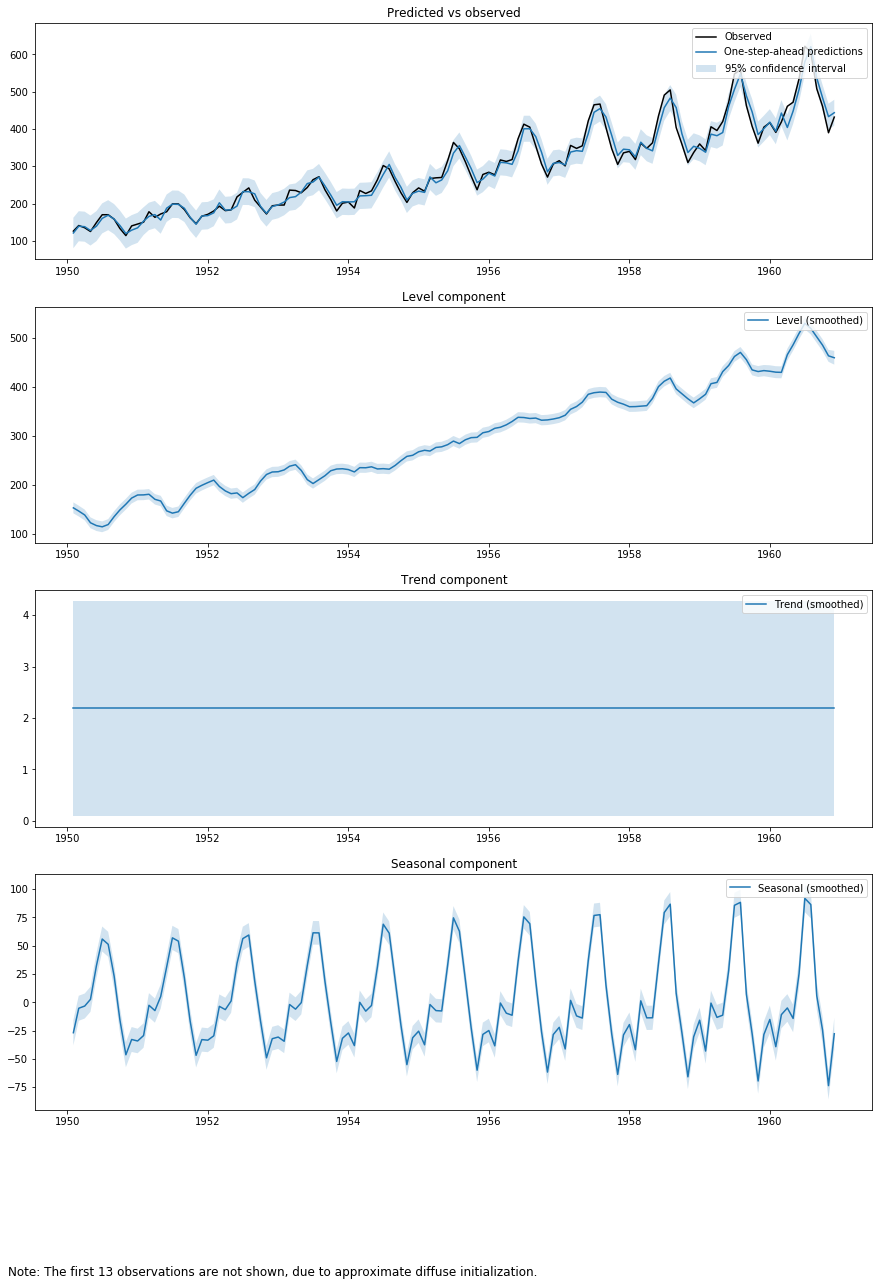

In [321]:
# 季節変動ありのローカル線形トレンドモデル

mod_season_trend = sm.tsa.UnobservedComponents(
    ts,
    'local linear trend',
    seasonal=12
)

# まずはNelder-Meadでパラメタを推定し、その結果を初期値としてまた最適化する。2回目はBFGSを使用。
res_season_trend = mod_season_trend.fit(
    method='bfgs', 
    maxiter=500, 
    start_params=mod_season_trend.fit(method='nm', maxiter=500).params,
)

# 推定されたパラメタ一覧
print(res_season_trend.summary())

# 推定された状態・トレンド・季節の影響の描画
rcParams['figure.figsize'] = 15, 20
fig = res_season_trend.plot_components()

C:\Users\ry00i\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 5.221190
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 5.221190
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                        Unobserved Components Results                         
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                   smooth trend   Log Likelihood                -751.851
Date:                Sat, 07 Mar 2020   AIC                           1507.703
Time:                        15:25:28   BIC                           1513.615
Sample:                    01-01-1949   HQIC                          1510.105
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|

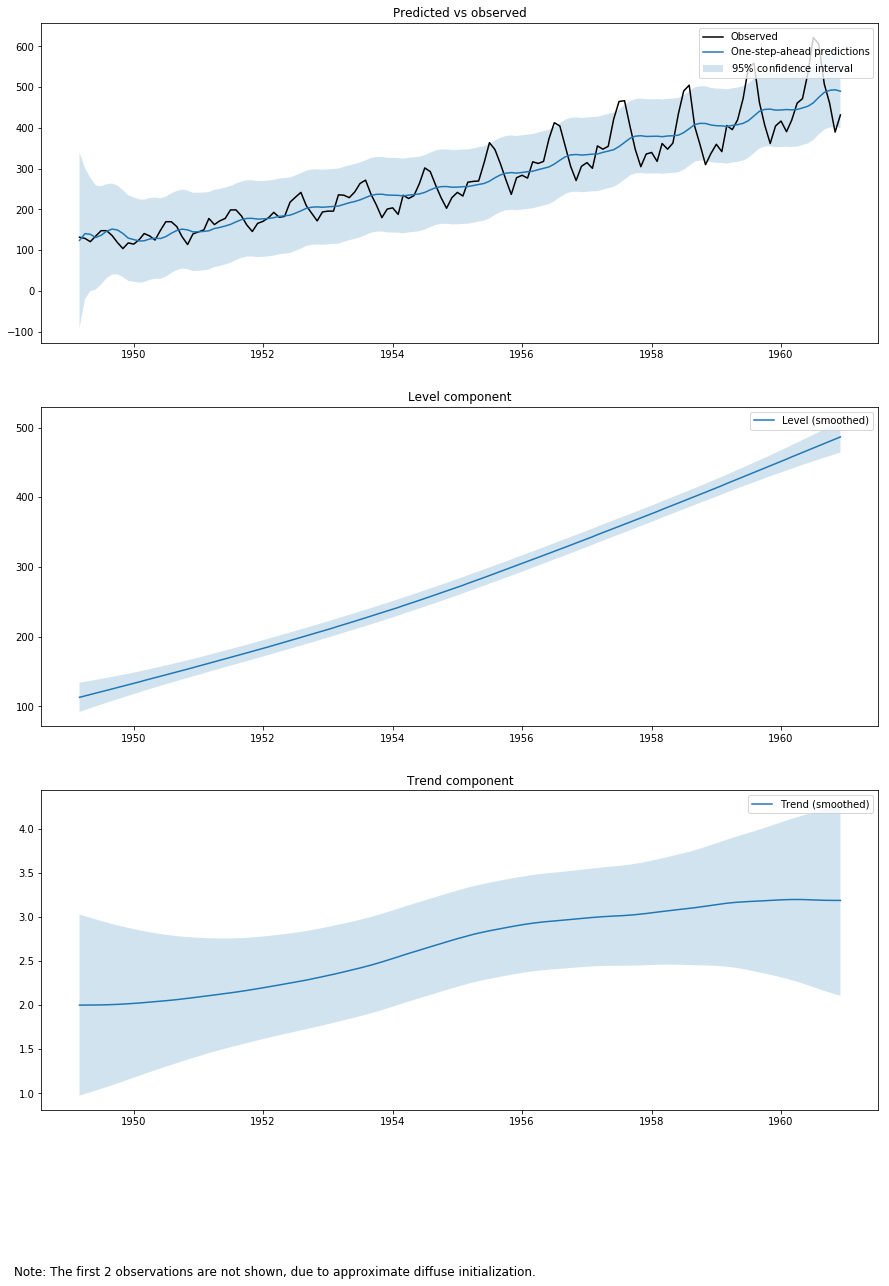

In [324]:
# 季節変動ありのローカル線形トレンドモデル

mod_season_trend = sm.tsa.UnobservedComponents(
    ts,
    'smooth trend'
)

# まずはNelder-Meadでパラメタを推定し、その結果を初期値としてまた最適化する。2回目はBFGSを使用。
res_season_trend = mod_season_trend.fit(
    method='bfgs', 
    maxiter=500, 
    start_params=mod_season_trend.fit(method='nm', maxiter=500).params,
)

# 推定されたパラメタ一覧
print(res_season_trend.summary())

# 推定された状態・トレンド・季節の影響の描画
rcParams['figure.figsize'] = 15, 20
fig = res_season_trend.plot_components()

In [ ]:
!pip install pystan